# 1. Setup

In [6]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [7]:
from mobilkit.umni import *
from project import *

In [8]:
from scipy.optimize import curve_fit

# 2. Load data

## 2.1. Zones

In [9]:
zones = gpd.read_parquet('../data/zones/zones2010.parquet').to_crs(CRS_M).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:3857


,geoid,name,aland,awater,geometry,scale
,<object>,<object>,<int64>,<int64>,<geometry>,<object>
0,18083,Knox,1336514262,20755159,"POLYGON ((-9741147.962964 4683574.018353, -974...",COUNTY


## 2.2. POIs

In [10]:
pois = gpd.read_parquet('../data/pois/safegraph.parquet').to_crs(CRS_M).disp()

59,308 rows x 9 cols; Memory: 14.6 MiB; CRS: EPSG:3857


,id,name,lon,lat,area_sqft,visits,visitors,category,geometry
,<object>,<object>,<float32>,<float32>,<float64>,<float64>,<float64>,<object>,<geometry>
0,222-222@5pt-wkp-dqf,Williamsport Day School,-87.28524,40.292946,7806.0,20.0,11.0,Essential services,POINT (-9716548.489865 4908604.139545)


## 2.3. Census

In [11]:
acs = pd.read_csv('../data/acs/acs_2013.csv').astype({'geoid': str}).disp()

4,808 rows x 33 cols; Memory: 1.5 MiB


,geoid,popu,hh,age_minor,age_adult,age_senior,age_median,sex_female,sex_male,race_white,race_black,edu_eligible,edu_bachelors,employ_total,employ_in_LF,employ_not_in_LF,inc_total,inc_avg,inc_total_hh,inc_median,pop_poor,pop_nonpoor,hh_poor,hh_nonpoor,cm_car,cm_pool,cm_pt,cm_bus,cm_subway,cm_taxi,cm_bike,cm_walk,cm_wfm
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,180571109041,1567.0,500.0,409.0,1016.0,58.0,39.5,817.0,750.0,1480.0,5.0,970.0,707.0,701.0,725.0,443.0,102434200.0,65370.0,102271000.0,168750.0,NaN,NaN,16.0,484.0,588.0,8.0,0.0,0.0,0.0,0.0,48.0,0.0,596.0


## 2.4. Travel times
Distance/time between each OD pair

In [13]:
tt = pd.read_parquet('../data/distance/travel_times.parquet')
tt = tt.assign(time=tt.time / 60).disp()

7,620,668 rows x 5 cols; Memory: 103.1 MiB


,source,target,time,scale,mode
,<category>,<category>,<float64>,<category>,<category>
0,18051,18083,32.183333,COUNTY,DRIVE


## 2.5. POI visit patterns

In [20]:
viz = (pd.read_parquet('../data/pois/safegraph_patterns.parquet')
       .astype(D(poi_id=str, home_bg=str))).disp()

1,927,345 rows x 3 cols; Memory: 273.9 MiB


,poi_id,home_bg,visitors
,<object>,<object>,<int32>
0,224-222@5pv-9z7-jvz,181095101001,41


## 2.6. Visitors OD table

In [9]:
visitors = (
    pois[['id', 'category', 'geometry']]
    .sjoin(zones.query('scale=="BG"')[['geoid', 'geometry']], predicate='within')
    .merge(viz[viz['home_bg'].str[:2] == '18'], left_on='id', right_on='poi_id')
    .rename(columns=D(home_bg='source', geoid='target'))
    .groupby(['category', 'source', 'target'])['visitors'].sum().reset_index()
).disp()

735,096 rows x 4 cols; Memory: 146.4 MiB


,category,source,target,visitors
,<object>,<object>,<object>,<int32>
0,Education,180010301001,180010301002,18


### 2.6.1. Total visitors per OD by mode & purpose

In [10]:
visitor_tt = (
    tt.assign(time=pd.cut(tt.time, np.arange(0, 90+1)))
    .merge(visitors, on=('source', 'target'))
    .groupby(['mode', 'category', 'time'])
    ['visitors'].sum().reset_index()
    .assign(time=lambda df: df.time.cat.codes + 1)
).disp()

2,520 rows x 4 cols; Memory: 0.3 MiB


,mode,category,time,visitors
,<object>,<object>,<int8>,<int32>
0,BIKE,Education,1,5


### 2.6.2. Total visitors per OD by mode

In [11]:
visitor_tt_mode = (
    visitor_tt.groupby(['mode', 'time'])
    ['visitors'].sum().reset_index()
).disp()

360 rows x 3 cols; Memory: 0.0 MiB


,mode,time,visitors
,<object>,<int8>,<int32>
0,BIKE,1,143


# 3. Visualize

## 3.1. Fit curves from literature

### 3.1.1. Driving
Cost impedance function for driving based on the E2SFCA formula in the project report.
$$ w(t) = \begin{cases} 1 & t\le 28\;\text{min} \\ \exp{\left(-\frac{1}{2}\left(\frac{t-28}{20}\right)^2\right)} & t>28\;\text{min} \end{cases} $$

/tmp/ipykernel_232299/3374804157.py:10: RuntimeWarning: divide by zero encountered in power
  f = lambda x, a, b: np.exp(-x**a / b)


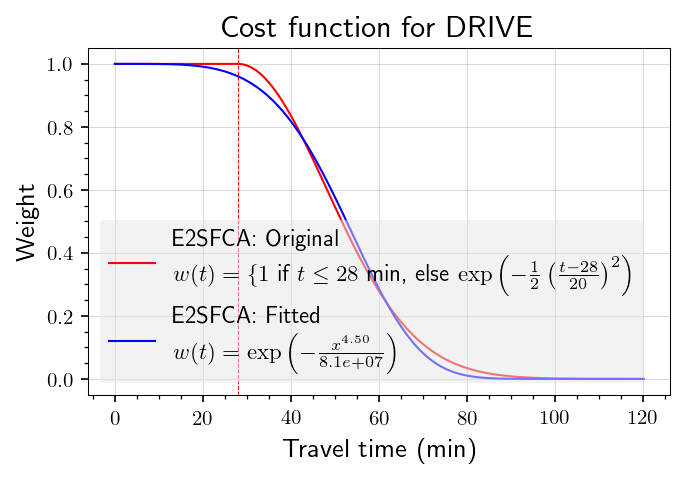

In [4]:
mpl.rc('text', usetex=True)
# with plt.rc_context({'text.latex.preamble': [r'\usepackage{amsmath}']}):
ax = U.plot(size=(5, 3), xlab='Travel time (min)', ylab='Weight', title='Cost function for DRIVE')
x = np.arange(121)
y = np.exp(-0.5*(x-28)**2/20**2)
y[x <= 28] = 1
formula = r'$w(t)=\{1$ if $t\le 28$ min, else $\exp{\left(-\frac{1}{2}\left(\frac{t-28}{20}\right)^2\right)}$'
ax.plot(x, y, 'r', lw=1, label=f'E2SFCA: Original\n{formula}')
ax.axvline(28, ls='--', color='r', lw=0.5)
f = lambda x, a, b: np.exp(-x**a / b)
a, b = curve_fit(f, x, y)[0]
formula = r'$w(t)=\exp\left({-\frac{x^{%.2f}}{%.1e}}\right)$' % (a, b)
# formula = 'asdsd'
ax.plot(x, f(x, a, b), 'b', lw=1, label=f'E2SFCA: Fitted\n{formula}')
ax.legend(loc='lower left');

### 3.1.2. Walking
Cost impedance function for walking, based on the WalkScore weight step function (**reference?**).

/tmp/ipykernel_232299/2080796086.py:4: RuntimeWarning: divide by zero encountered in power
  f = lambda x, a, b: np.exp(-x**a / b)


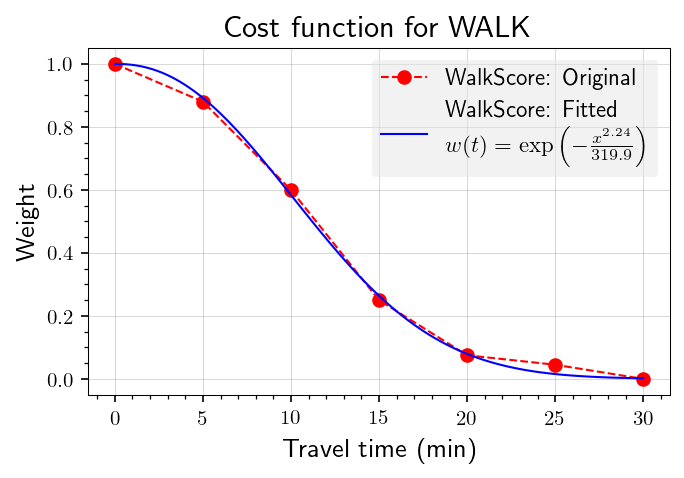

In [5]:
ax = U.plot(size=(5, 3), xlab='Travel time (min)', ylab='Weight', title='Cost function for WALK')
x, y = (0, 5, 10, 15, 20, 25, 30), (1., .88, .60, .25, .075, .045, 0)
ax.plot(x, y, '--ro', lw=1, label='WalkScore: Original')
f = lambda x, a, b: np.exp(-x**a / b)
a, b = curve_fit(f, x, y)[0]
# a, b = 2.16, 267.4
formula = r'$w(t)=\exp\left({-\frac{x^{%.2f}}{%.1f}}\right)$' % (a, b)
x = np.linspace(0, 30, 100)
ax.plot(x, f(x, a, b), 'b', lw=1, label=f'WalkScore: Fitted\n{formula}')
ax.legend();

## 3.2. Overall distribution

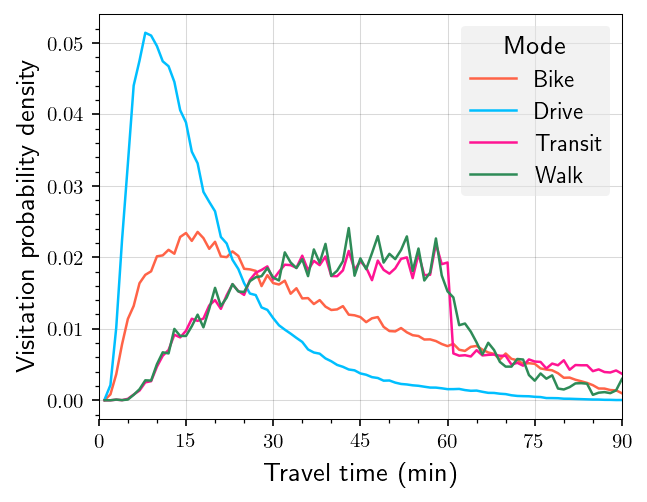

In [12]:
ax = U.plot(size=(4.5, 3.5), xlim=(0, 90),
            ylab='Visitation probability density')
for mode, df in visitor_tt_mode.groupby('mode'):
    color = MODES.loc[mode, 'color']
    y = (df.visitors / df.visitors.sum()).set_axis(df.time)
    y.plot(ax=ax, color=color, lw=1.2, label=mode.title())
ax.set_xticks(np.arange(0, 90+1, 15))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.set_xlabel('Travel time (min)')
ax.legend(title='Mode', loc='upper right');

In [13]:
# ax = U.plot(size=(4.5, 3.5), xlim=(0, 90),
#             ylab='Visitation probability density')
# for (mode, cat), df in visitor_tt.groupby(['mode', 'category']):
#     color = MODES.loc[mode, 'color']
#     y = (df.visitors / df.visitors.sum()).set_axis(df.time).sort_index()
#     y.plot(ax=ax, color=color, lw=1.2, label=f'{mode.title()}: {cat}')
# ax.set_xticks(np.arange(0, 90+1, 15))
# ax.set_xlabel('Travel time (min)')
# ax.legend(title='Mode', loc='upper right');

## 3.3. Curve fitting

### 3.3.1. By mode

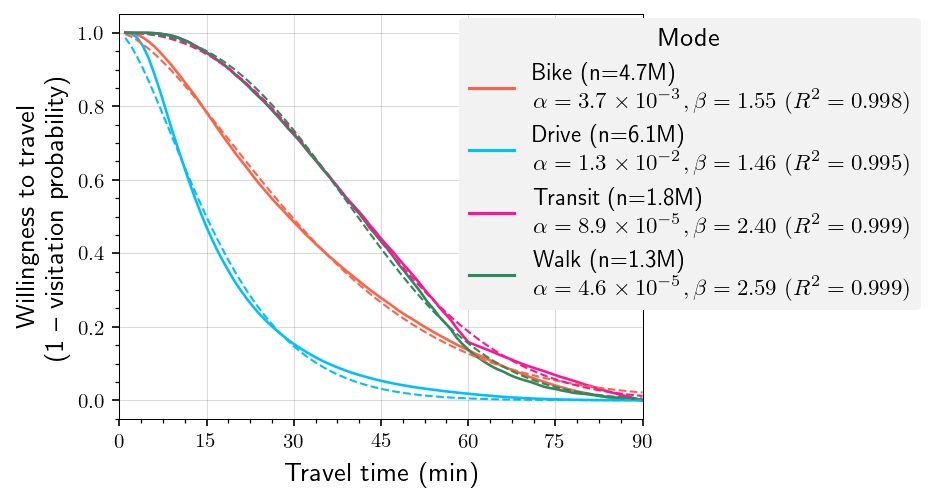

In [14]:
ax = U.plot(size=(4.5, 3.5), xlim=(0, 90),
            ylab='Willingness to travel\n(1 – visitation probability)')
def f(x, a, b): return np.exp(-a * (x**b))
labels = []
for mode, df in visitor_tt_mode.groupby('mode'):
    color = MODES.loc[mode, 'color']
    x = df.time
    y = 1 - (df.visitors / df.visitors.sum()).set_axis(x).sort_index().cumsum()
    a, b = curve_fit(f, x, y)[0]
    fitted = f(x, a, b).set_axis(x.values)
    r2 = 1 - ((fitted - y)**2).sum() / ((y - y.mean())**2).sum()
    exp = int(np.floor(np.log10(a)))
    alpha = f'{a:.1e}'.replace('e%03d' % exp, r'\times 10^{%d}' % exp)
    label = r'$\alpha=%s, \beta=%.2f\;(R^2=%.3f)$' % (alpha, b, r2)
    label = f'{mode.title()} (n={df.visitors.sum() / 1e6:.1f}M)\n{label}'
    labels += [(label, color)]
    y.plot(ax=ax, color=color, lw=1.25)
    fitted.plot(ax=ax, color=color, ls='--', lw=1, zorder=20)
ax.set_xticks(np.arange(0, 90+1, 15))
ax.set_xlabel('Travel time (min)')
ax.legend(handles=[mpl.lines.Line2D([0], [0], color=c, label=l) for l, c in labels],
          title='Mode', loc=(0.65, 0.27), framealpha=1, facecolor='0.95');

### 3.3.2. Weighted by probability

In [15]:
trip_wts = (pd.read_csv('../data/nhts/trip-duration-distr-by-mode.csv')
            .melt('t').rename(columns=D(t='time', variable='mode', value='wt'))).disp()

360 rows x 3 cols; Memory: 0.0 MiB


,time,mode,wt
,<int64>,<object>,<float64>
0,1,BIKE,0.010989


In [16]:
wtd_visitor_tt_mode = (visitor_tt_mode.merge(trip_wts, on=('time', 'mode'))
                       .assign(wtd_visitors=lambda df: df.visitors * df.wt)).disp()

360 rows x 5 cols; Memory: 0.0 MiB


,mode,time,visitors,wt,wtd_visitors
,<object>,<int8>,<int32>,<float64>,<float64>
0,BIKE,1,143,0.010989,1.571429


Text(0.5, 0, 'Travel time (min)')

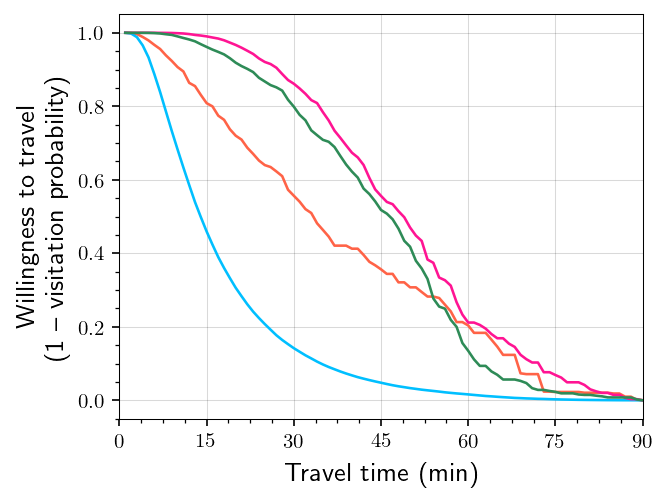

In [17]:
ax = U.plot(size=(4.5, 3.5), xlim=(0, 90),
            ylab='Willingness to travel\n(1 – visitation probability)')
def f(x, a, b): return np.exp(-a * (x**b))
labels = []
for mode, df in wtd_visitor_tt_mode.groupby('mode'):
    color = MODES.loc[mode, 'color']
    x = df.time
    y = 1 - (df.wtd_visitors / df.wtd_visitors.sum()).set_axis(x).sort_index().cumsum()
    # a, b = curve_fit(f, x, y)[0]
    # fitted = f(x, a, b).set_axis(x.values)
    # r2 = 1 - ((fitted - y)**2).sum() / ((y - y.mean())**2).sum()
    # exp = int(np.floor(np.log10(a)))
    # alpha = f'{a:.1e}'.replace('e%03d' % exp, r'\times 10^{%d}' % exp)
    # label = r'$\alpha=%s, \beta=%.2f\;(R^2=%.3f)$' % (alpha, b, r2)
    # label = f'{mode.title()} (n={df.visitors.sum() / 1e6:.1f}M)\n{label}'
    # labels += [(label, color)]
    y.plot(ax=ax, color=color, lw=1.25)
    # fitted.plot(ax=ax, color=color, ls='--', lw=1, zorder=20)
ax.set_xticks(np.arange(0, 90+1, 15))
ax.set_xlabel('Travel time (min)')
# ax.legend(handles=[mpl.lines.Line2D([0], [0], color=c, label=l) for l, c in labels],
#           title='Mode', loc=(0.65, 0.27), framealpha=1, facecolor='0.95');

### 3.3.3. By mode and purpose

In [18]:
res = []
for (mode, cat), df in visitor_tt.groupby(['mode', 'category']):
    x = df.time
    y = 1 - (df.visitors / df.visitors.sum()).set_axis(x).sort_index().cumsum()
    a, b = curve_fit(f, x, y)[0]
    fitted = f(x, a, b).set_axis(x.values)
    r2 = 1 - ((fitted - y)**2).sum() / ((y - y.mean())**2).sum()
    res.append(D(mode=mode.title(), purpose=cat, n_visitors=df.visitors.sum(),
                    alpha=a, beta=b, rsquared=r2))
res = Pdf(res).disp()

28 rows x 6 cols; Memory: 0.0 MiB


,mode,purpose,n_visitors,alpha,beta,rsquared
,<object>,<object>,<int64>,<float64>,<float64>,<float64>
0,Bike,Education,332341,0.003238,1.582208,0.998871


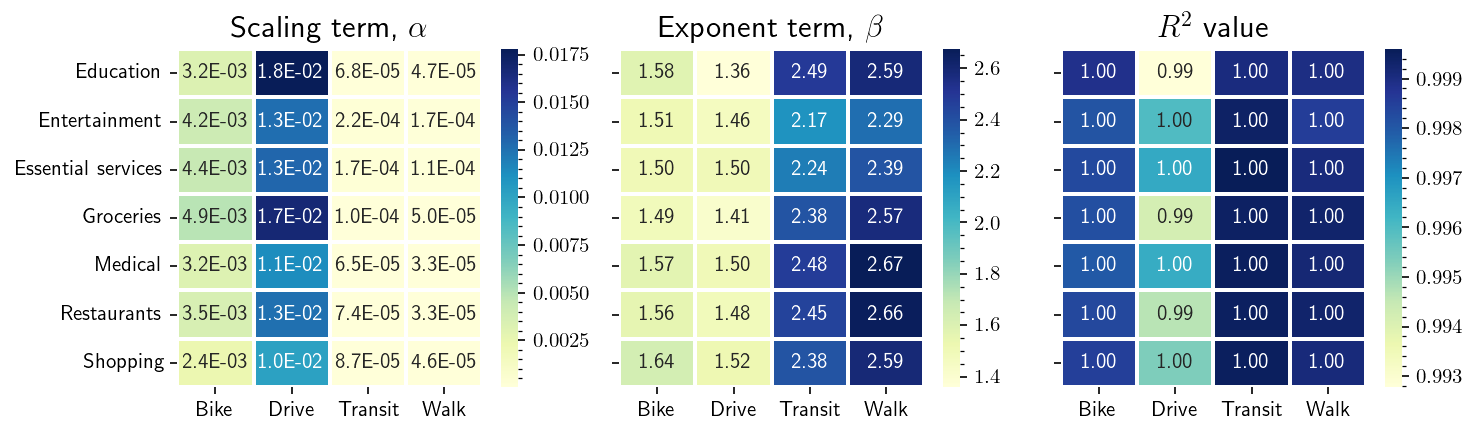

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, (var, label, fmt) in enumerate([
    ('alpha', r'Scaling term, $\alpha$', '.1E'),
    ('beta', r'Exponent term, $\beta$', '.2f'),
    ('rsquared', r'$R^2$ value', '.2f'),
]):
    df = res.pivot_table(var, 'purpose', 'mode')
    ax = sns.heatmap(df, ax=axes[i], cmap='YlGnBu', linewidths=1,
                     annot=True, fmt=fmt, annot_kws=D(fontsize=10))
    ax = U.plot(ax, title=label, xlab='', ylab='')
    ax.grid(False)
    ax.minorticks_off()
plt.tight_layout()

In [21]:
df = pd.read_parquet('../data/aaa/transit/30_min.parquet').disp()

259,425 rows x 92 cols; Memory: 93.0 MiB


,w_c000,w_ca01,w_ca02,w_ca03,w_ce01,w_ce02,w_ce03,w_cns01,w_cns02,w_cns03,w_cns04,w_cns05,w_cns06,w_cns07,w_cns08,w_cns09,w_cns10,w_cns11,w_cns12,w_cns13,w_cns14,w_cns15,w_cns16,w_cns17,w_cns18,w_cns19,w_cns20,w_cr01,w_cr02,w_cr03,w_cr04,w_cr05,w_cr07,w_ct01,w_ct02,w_cd01,w_cd02,w_cd03,w_cd04,w_cs01,w_cs02,w_cfa01,w_cfa02,w_cfa03,w_cfa04,w_cfa05,w_cfs01,w_cfs02,w_cfs03,w_cfs04,w_cfs05,r_c000,r_ca01,r_ca02,r_ca03,r_ce01,r_ce02,r_ce03,r_cns01,r_cns02,r_cns03,r_cns04,r_cns05,r_cns06,r_cns07,r_cns08,r_cns09,r_cns10,r_cns11,r_cns12,r_cns13,r_cns14,r_cns15,r_cns16,r_cns17,r_cns18,r_cns19,r_cns20,r_cr01,r_cr02,r_cr03,r_cr04,r_cr05,r_cr07,r_ct01,r_ct02,r_cd01,r_cd02,r_cd03,r_cd04,r_cs01,r_cs02
geoid,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>
180010301001000,8,1,4,3,0,6,2,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,8,0,0,4,2,1,6,2,0,0,0,0,0,0,0,0,0,0,107,26,53,28,29,29,49,0,0,0,4,27,6,11,7,2,0,1,5,0,4,10,16,1,4,4,5,101,2,4,0,0,0,103,4,6,24,26,25,62,45
